In [13]:
from __future__ import annotations

import operator
from typing import TypedDict, List, Annotated

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage

In [14]:
class Task(BaseModel):
    id: int
    title: str
    brief: str = Field(..., description="What to cover")

In [15]:
class Plan(BaseModel):
    blog_title: str
    tasks: List[Task]

In [16]:
class State(TypedDict):
    topic: str
    plan: Plan
    sections: Annotated[List[str], operator.add]
    final: str

In [17]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [18]:
def orchestrator(state: State) -> dict:

    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content = (
                     "Create a blog plan with 5-7 sections on the following topic."
                )
            ),
            HumanMessage(content = f"Topic: {state['topic']}"),
        ]
    )
    return {"plan": plan}

In [19]:
def fanout(state: State):
    return [Send("worker", 
                 {"task": task, "topic": state["topic"], "plan": state["plan"]})
                 for task in state["plan"].tasks]

In [9]:
def worker(payload: dict) -> dict:

    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]

    blog_title = plan.blog_title

    section_md = llm.invoke(
        [
            SystemMessage(content="Write one clean Marrkdown section."),
            HumanMessage(content=(
                f"Blog: {blog_title}\n"
                f"Topic: {topic}\n\n"
                f"Section: {task.title}\n"
                f"Brief: {task.brief}\n\n"
                "Return only the section content in Markdown."
            )
            ),
        ]
    ).content.strip()

    return {"sections": [section_md]}

In [20]:
from pathlib import Path

def reducer(state: State) -> dict:

    title = state["plan"].blog_title
    body = "\n\n".join(state["sections"]).strip()

    final_md = f"# {title}\n\n{body}\n"

    filename = title.lower().replace(" ", "_") + ".md"
    output_path = Path(filename)
    output_path.write_text(final_md, encoding="utf-8")

    return {"final": final_md}

In [21]:
graph = StateGraph(State)
graph.add_node("orchestrator", orchestrator)
graph.add_node("worker", worker)
graph.add_node("reducer", reducer)

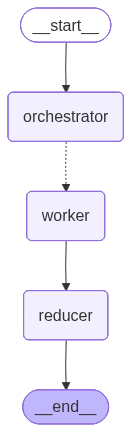

In [22]:
graph.add_edge(START, "orchestrator")
graph.add_conditional_edges("orchestrator", fanout, ["worker"])
graph.add_edge("worker", "reducer")
graph.add_edge("reducer", END)

app = graph.compile()

app

In [17]:
out = app.invoke({"topic": "Write a blog on Self Attention", "sections":[]})

In [18]:
out

{'topic': 'Write a blog on Self Attention',
 'plan': Plan(blog_title='Understanding Self-Attention in Deep Learning', tasks=[Task(id=1, title='Introduction to Self-Attention', brief='Define self-attention, its importance, and applications in deep learning'), Task(id=2, title='The Mechanism of Self-Attention', brief='Explain the mathematical formulation and step-by-step process of self-attention'), Task(id=3, title='Types of Self-Attention', brief='Discuss different variants such as local self-attention, global self-attention, and hierarchical self-attention'), Task(id=4, title='Self-Attention in Transformers', brief='Describe the role of self-attention in transformer architectures and its impact on sequence-to-sequence models'), Task(id=5, title='Advantages and Limitations', brief='List the benefits and drawbacks of using self-attention in deep learning models'), Task(id=6, title='Real-World Applications', brief='Provide examples of self-attention in natural language processing, comput

In [23]:
rag_out = app.invoke({"topic": "Write a blog on Agentic Rag", "sections":[]})

In [24]:
rag_out

{'topic': 'Write a blog on Agentic Rag',
 'plan': Plan(blog_title='Agentic Rag', tasks=[Task(id=1, title='Introduction to Agentic Rag', brief='Define Agentic Rag and its significance'), Task(id=2, title='History of Agentic Rag', brief='Discuss the origins and evolution of Agentic Rag'), Task(id=3, title='Key Features of Agentic Rag', brief='Describe the main characteristics of Agentic Rag'), Task(id=4, title='Benefits of Agentic Rag', brief='Explain the advantages of using Agentic Rag'), Task(id=5, title='Challenges and Limitations of Agentic Rag', brief='Discuss the potential drawbacks and limitations of Agentic Rag'), Task(id=6, title='Real-World Applications of Agentic Rag', brief='Provide examples of how Agentic Rag is used in practice'), Task(id=7, title='Conclusion and Future Directions', brief='Summarize the main points and discuss future prospects for Agentic Rag')]),
 'sections': ['## Introduction to Agentic Rag\nAgentic Rag refers to a theoretical framework that emphasizes th

In [25]:
rag_out = app.invoke({"topic": "Write a blog on Agentic RAG", "sections":[]})

In [26]:
rag_out

{'topic': 'Write a blog on Agentic RAG',
 'plan': Plan(blog_title='Understanding Agentic RAG', tasks=[Task(id=1, title='Introduction to Agentic RAG', brief='Define Agentic RAG and its importance'), Task(id=2, title='Key Components of Agentic RAG', brief='Discuss the key components of Agentic RAG'), Task(id=3, title='Benefits of Agentic RAG', brief='Explain the benefits of using Agentic RAG'), Task(id=4, title='Challenges in Implementing Agentic RAG', brief='Discuss the challenges of implementing Agentic RAG'), Task(id=5, title='Real-World Applications of Agentic RAG', brief='Provide examples of real-world applications of Agentic RAG'), Task(id=6, title='Best Practices for Agentic RAG', brief='Offer best practices for implementing and using Agentic RAG'), Task(id=7, title='Conclusion', brief='Summarize the key points and takeaways from the blog')]),
 'sections': ['## Introduction to Agentic RAG\nAgentic RAG, which stands for Retrieval-Augmented Generation, is an artificial intelligence 